In [1]:
%load_ext autoreload

In [8]:
%autoreload 2

from copy import deepcopy
import logging
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *
from plot_utils import barplot_annotate_brackets

sys.path.append('/om2/user/eisenaj/code/DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

plt.style.use('../sci_style.py')

# Load Data

In [3]:
# # session = 'Mary-Anesthesia-20160912-02'
# # session = 'MrJones-Anesthesia-20160109-01'
# # session = 'Mary-Anesthesia-20160826-02'
# # session = 'MrJones-Anesthesia-20160107-01'
# # session = 'Mary-Anesthesia-20160822-02'
# # session = 'MrJones-Anesthesia-20160113-01'
# # session = 'Mary-Anesthesia-20160809-01'
# # session = 'MrJones-Anesthesia-20160121-01'
# # session = 'Mary-Anesthesia-20160831-02'
# session = 'MrJones-Anesthesia-20160105-01'

# session_list = ['Mary-Anesthesia-20160912-02',
# 'MrJones-Anesthesia-20160109-01',
# 'Mary-Anesthesia-20160826-02',
# 'MrJones-Anesthesia-20160107-01']

# max_freq = 500
# max_unstable_freq = 125
norm = False

results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

session_list = os.listdir(results_dir)

In [4]:
session_rets = {}
for session in tqdm(session_list):
    print("-"*30)
    print(f'SESSION = {session}')
    print("-"*30)
    session_rets[session] = {}
    # ---------------------------------
    # LOAD DATA
    # --------------------------------
    print("loading data...")
    all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
    data_class = get_data_class(session, all_data_dir)

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

    section_times = dict( 
            wake=(0, session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            anesthesia=(eyes_close, session_info['drugEnd'][1]),
            recovery=(session_info['drugEnd'][1], T*dt)
    )
    sections = list(section_times.keys())
    
    session_rets[session]['electrode_info'] = electrode_info
    session_rets[session]['session_info'] = session_info
    session_rets[session]['eyes_open'] = eyes_open
    session_rets[session]['eyes_close'] = eyes_close
    session_rets[session]['section_times'] = section_times
    session_rets[session]['sections'] = sections
    
    print("data loaded!")
    print("loading results...")
    norm_dir = "NORMED" if norm else "NOT_NORMED"
    total = 0
    for area in os.listdir(os.path.join(results_dir, session, norm_dir)):
        total += len(os.listdir(os.path.join(results_dir, session, norm_dir, area)))
    
    results_dict = {}
    iterator = tqdm(total=total)
    for area in os.listdir(os.path.join(results_dir, session, norm_dir)):
        results_dict[area] = None
        for f in os.listdir(os.path.join(results_dir, session, norm_dir, area)):
            t = float(f.split('_')[0])
            df = pd.DataFrame(pd.read_pickle(os.path.join(results_dir, session, norm_dir, area, f)))
            if len(df) > 0:
                df['area'] = area
                df['start_time'] = t
                df['end_time'] = t + df.window*dt
                df['start_ind'] = int(t/dt)
                df['end_ind'] = int(t/dt) + df.window

                if results_dict[area] is None:
                    results_dict[area] = df
                else:
                    results_dict[area] = pd.concat([results_dict[area], df])
            else:
                print(f"{area}/{f} is empty")
            iterator.update()
        results_dict[area] = results_dict[area].sort_values('start_time')
    
    session_rets[session]['results_dict'] = results_dict
    
    print("results loaded!")
    iterator.close()

  0%|          | 0/21 [00:00<?, ?it/s]

------------------------------
SESSION = MrJones-Anesthesia-20160206-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3555 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160201-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3390 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160109-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/4060 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160121-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3370 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160902-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2300 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160818-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/1885 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160908-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2210 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160105-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/4155 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160914-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2065 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160107-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/4360 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160831-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2065 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160809-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2360 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160125-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3360 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160912-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2165 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160826-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2250 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160210-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3250 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160822-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2015 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160301-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3300 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160123-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3885 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = MrJones-Anesthesia-20160113-01
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/3490 [00:00<?, ?it/s]

results loaded!
------------------------------
SESSION = Mary-Anesthesia-20160916-02
------------------------------
loading data...
data loaded!
loading results...


  0%|          | 0/2155 [00:00<?, ?it/s]

results loaded!


In [5]:
session = session_list[0]

In [7]:
# pd.to_pickle(session_rets, os.path.join("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp", "all_session_rets.pkl"))\
# session_rets = pd.read_pickle(os.path.join("/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp", "all_session_rets.pkl"))

# Preprocess Data

In [9]:
top_percent = 0.1

In [111]:
leadup_time = 18 # minutes before anesthesia
post_time = 25 # minutes after anesthesia
dt_stab = 0.1
split_by_monkey = True
stability_all = {}
freqs_all = {}
counts = {}
if split_by_monkey:
    monkeys = ['Mary', 'MrJones']
    monkey_sessions = {monkey: [session for session in session_list if monkey in session] for monkey in monkeys}
    session_dicts = {monkey: {session: session_rets[session] for session in monkey_sessions[monkey]} for monkey in monkeys}
    num_sessions = {key: len(value) for key, value in monkey_sessions.items()}
else:
    monkeys = ['Combined']
    monkey_sessions = {'Combined': session_list}
    session_dicts = {'Combined': session_rets}
    num_sessions = {key: len(value) for key, value in monkey_sessions.items()}
    
for monkey in monkeys:
    stability_all[monkey] = {}
    freqs_all[monkey] = {}
    counts[monkey] = {}
    
# areas = ['vlPFC', 'FEF', '7b', 'CPB']
areas = ['vlPFC', 'FEF', '7b', 'CPB', 'all']

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))

iterator = tqdm(total=total_its)

for monkey in monkeys:
    for area in areas:
        # num_params = np.min([len(session_dict['results_dict'][area].stability_params.iloc[0]) for session_dict in session_rets.values()])
        stability_all[monkey][area] = np.zeros((int((leadup_time + 60 + post_time)*60*(1/dt_stab)), num_sessions[monkey]), dtype=np.float32)
        freqs_all[monkey][area] = np.zeros(stability_all[monkey][area].shape, dtype=np.float32)
        counts[monkey][area] = np.zeros(stability_all[monkey][area].shape, dtype=np.int16)
        # raise ValueError
        for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
            filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
            for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
                end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
                if start_ind > len(stability_all[monkey][area]):
                    print(start_ind, len(stability_all[monkey][area]))
                    raise ValueError
                # there are a few points where the time windows overlap but I decided to just
                # overwrite the data. it's only like 7 or 8 points
                stability_all[monkey][area][start_ind:end_ind, session_ind] = row.stability_params[:int(top_percent*len(row.stability_params))].mean()
                freqs_all[monkey][area][start_ind:end_ind, session_ind] = row.stability_freqs[:int(top_percent*len(row.stability_freqs))].mean()
                counts[monkey][area][start_ind:end_ind, session_ind] = 1
                # counts[monkey][area][start_ind:end_ind, session_ind] += 1
                # np.where(counts[monkey][area][time_inds] == 2)
                iterator.update()
iterator.close()

  0%|          | 0/42945 [00:00<?, ?it/s]

In [11]:
palette1 = ['#045275', # dark blue
            '#089099', # teal
            '#7ccba2', # green
            '#fcde9c', # yellow
            '#f0746e', # orange
            '#dc3977', #pink
            '#7c1d6f', #purple
           ]

palette2 = ['#648fff', # blue
            '#785ef0', # midnight
            '#dc267f', # pink
            '#fcde9c', # orange
            '#FE6100', # orange
            '#FFB000', # yellow
           ]

In [12]:
area_colors = {
    'vlPFC': 'C0',
    'FEF': 'skyblue',
    '7b': 'slategray',
    'CPB': 'lightsteelblue', 
    'all': 'purple'
}
section_colors = {
    'awake': 'limegreen',
    'unconscious': 'plum',
    'recovery': 'orange'
}
# area_colors = {
#     'vlPFC': palette2[0], 
#     'FEF': palette2[2],
#     '7b': palette2[3],
#     'CPB': palette2[4]
# }
area_labels = {
    'CPB': 'STG',
    '7b': 'PPC',
    'FEF': 'FEF',
    'vlPFC': 'PFC',
    'all': 'ALL'
}

In [13]:
figure4_data = {}

# Figure 5a

In [14]:
img_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/images"
data_save_dir = "/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/figure_data"

In [15]:
eyes_closes = {}
eyes_opens = {}
for monkey in monkeys:
    eyes_closes[monkey] = []
    eyes_opens[monkey] = []
    for session, session_dict in session_rets.items():
        if len(monkey) == 1 or monkey in session:
            
            eyes_closes[monkey].append(session_dict['eyes_close'] - session_dict['session_info']['drugStart'][0])
            eyes_opens[monkey].append(session_dict['eyes_open']  - session_dict['session_info']['drugStart'][0])

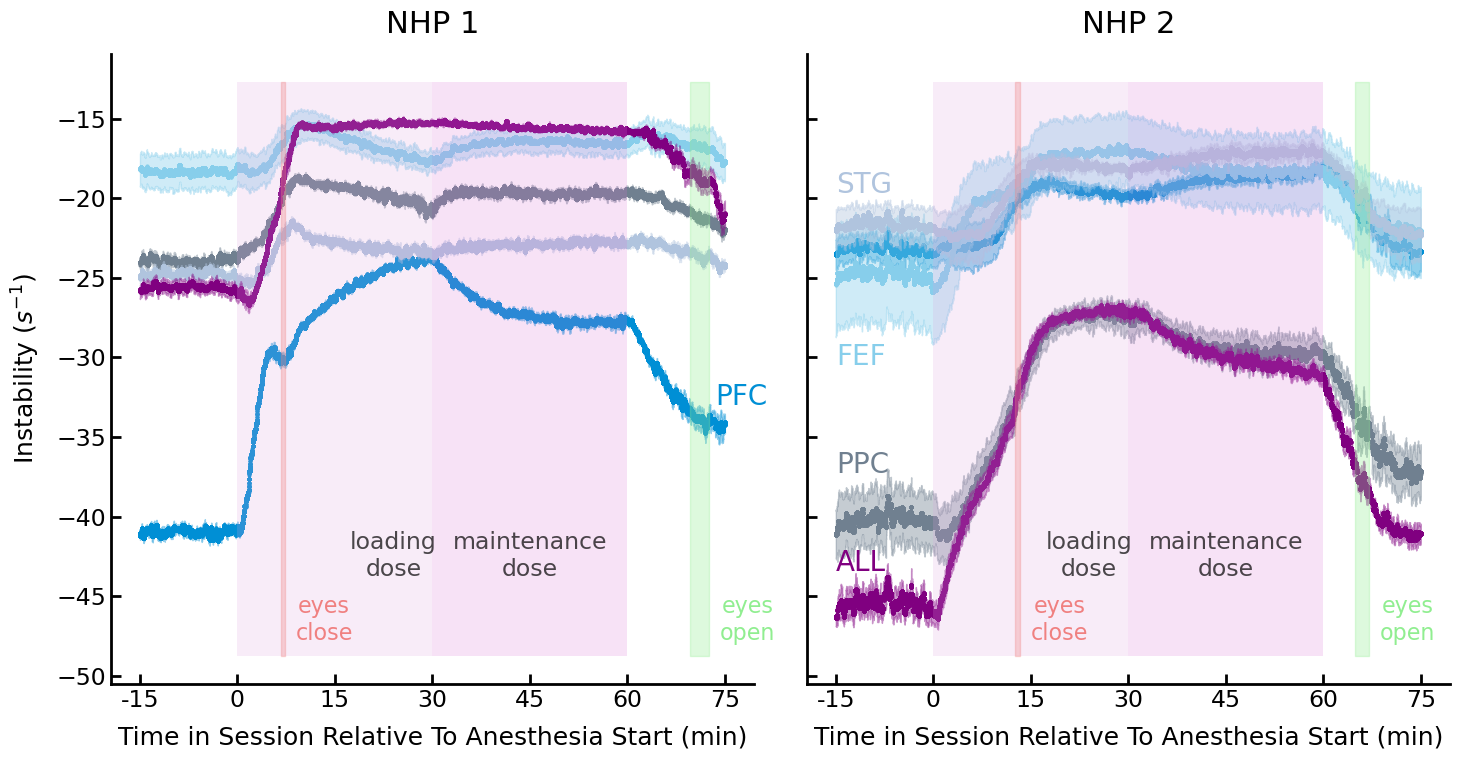

In [16]:
xlabel_fontsize= 18
ylabel_fontsize= 18
tick_fontsize=17
title_fontsize = 22
onplot_fontsize=20

time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
plot_start_time = -15
plot_end_time = 60 + 15
s = 4
time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

lns = []

for i, monkey in enumerate(monkeys):
    ax = axs[i]
    for area in stability_all[monkey].keys():
        # raise ValueError
        mean_vals = stability_all[monkey][area][time_inds].sum(axis=-1)/counts[monkey][area][time_inds].sum(axis=-1)
        std_dev_vals = np.sqrt(np.square(stability_all[monkey][area][time_inds] - np.expand_dims(mean_vals, -1)).sum(axis=-1)/(counts[monkey][area][time_inds].sum(axis=-1) - 1))
        se_vals = std_dev_vals/np.sqrt(counts[monkey][area][time_inds].sum(axis=-1))
        ax.scatter(time_vals[time_inds], mean_vals, label=area_labels[area], color=area_colors[area], s=s)
        # ax.errorbar(time_vals[time_inds], mean_vals, color=area_colors[area], yerr=se_vals, ls='none', alpha=0.4)
        ax.fill_between(time_vals[time_inds], mean_vals - se_vals, mean_vals + se_vals, color=area_colors[area], alpha=0.4)
        #         lower_bound = mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0] - se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0]
#         upper_bound = mean_stab_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0] + se_all[monkey][area][time_inds][counts_safe_all[monkey][area][time_inds] > 0]
#         ax.fill_between(time_vals[time_inds][counts_safe_all[monkey][area][time_inds] > 0], lower_bound, upper_bound, alpha=0.4, color=area_colors[area])
        
        if i == 0:
            ln1 = ax.plot([], label=area_labels[area], color=area_colors[area])
            lns += ln1
            
            if area == 'vlPFC':
                ax.text(60 + (plot_end_time - 60)*0.9, stability_all[monkey][area][time_vals >= 60].mean() - 2, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
        if i == 1:
            if area == '7b':
                ax.text(-15, stability_all[monkey][area][time_vals <= 0].mean() + 2.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
            if area == 'FEF':
                ax.text(-15, stability_all[monkey][area][time_vals <= 0].mean() - 5.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
            if area == 'CPB':
                ax.text(-15, stability_all[monkey][area][time_vals <= 0].mean() + 1.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
                
            if area == 'all':
                ax.text(-15, stability_all[monkey][area][time_vals <= 0].mean() + 1.8, area_labels[area], color=area_colors[area], fontsize=onplot_fontsize)
ylim = ax.get_ylim()
for i in range(2):
    ax = axs[i]
    fill1 = ax.fill_betweenx(ylim, 0, 30, color='plum', alpha=0.2, label='infusion 1', edgecolor='none')
    fill2 = ax.fill_betweenx(ylim, 30, 60, color='orchid', alpha=0.2, label='infusion 2', edgecolor='none')
    ax.text(24, ylim[0] + 5, 'loading\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    ax.text(45, ylim[0] + 5, 'maintenance\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    if i == 0:
        lns += plt.plot([], c=fill1.get_facecolors()[0], label=fill1.get_label())
        lns += plt.plot([], c=fill2.get_facecolors()[0], label=fill2.get_label())
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        # ax.set_ylabel(f'Mean of Top {top_percent*100:.0f}% Instability ' + r'($s^{-1}$)', fontsize=ylabel_fontsize)
        ax.set_ylabel(f'Instability ' + r'($s^{-1}$)', fontsize=ylabel_fontsize)
    else:
#         ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='y', which='both', left=True, right=False)
    
    xticks = [-15, 0, 15, 30, 45, 60, 75]
    ax.set_xticks(xticks, xticks)
    ax.set_xlabel('Time in Session Relative To Anesthesia Start (min)', fontsize=xlabel_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_title(f'NHP {i + 1}', fontsize=title_fontsize)
    
    mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
    se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_close - se_eyes_close)/60, (mean_eyes_close + se_eyes_close)/60, alpha=0.3, color='lightcoral')
    ax.text((mean_eyes_close + se_eyes_close)/60 + 6, ylim[0] + 1, 'eyes\nclose', color='lightcoral', fontsize=onplot_fontsize - 4, horizontalalignment='center')
    
    mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
    se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_open - se_eyes_open)/60, (mean_eyes_open + se_eyes_open)/60, alpha=0.3, color='lightgreen')
    ax.text((mean_eyes_open + se_eyes_open)/60 + 6, ylim[0] + 1, 'eyes\nopen', color='lightgreen', fontsize=onplot_fontsize - 4, horizontalalignment='center')
# fig.legend(lns, [ln.get_label() for ln in lns], bbox_to_anchor=(0.9, -0.01), ncol=len(lns), fontsize=legend_fontsize)
plt.tight_layout()
# plt.savefig(os.path.join(img_save_dir, "main", "stability-neural-all.pdf"), bbox_inches='tight', transparent=True)
plt.show()

# Figure 5b + S2a

In [17]:
top_percent = 0.1
# https://blogs.sas.com/content/iml/2019/10/02/geometric-mean-deviation-cv-sas.html

In [18]:
leadup_time = 15 # minutes before anesthesia
post_time = 15 # minutes after anesthesia

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)

changes_all = {}
counts_changes = {}

for monkey in monkeys:
    changes_all[monkey] = {}
    counts_changes[monkey] = {}
    for area in stability_all[monkey].keys():
        changes_all[monkey][area] = np.zeros((int((leadup_time + 60 + post_time)*60*(1/dt_stab)), num_sessions[monkey]), dtype=np.float32)
        counts_changes[monkey][area] = np.zeros(changes_all[monkey][area].shape, dtype=np.int32)
        for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
            filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
            wake_rows = session_dict['results_dict'][area][np.logical_and(filter_inds, session_dict['results_dict'][area].end_time < session_dict['session_info']['drugStart'][0])]
            wakeful_mean = np.exp(np.log(-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]).to_numpy())).mean())
            # wakeful_mean = np.mean(-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]).to_numpy()))
            if wakeful_mean < 0:
                raise ValueError
            for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
                end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
                row_vals = -1/row.stability_params[row.stability_params <= 0][:int(top_percent*len(row.stability_params))]
                changes_all[monkey][area][start_ind:end_ind, session_ind] = np.exp(np.sum(np.log(row_vals/wakeful_mean))/len(row_vals))
                counts_changes[monkey][area][start_ind:end_ind, session_ind] = 1
                iterator.update()
        
        # counts_safe = np.copy(counts_changes[monkey][area])
        # changes_all[monkey][area][counts_safe > 0] = np.exp(changes_all[monkey][area][counts_safe > 0]/counts_safe[counts_safe > 0])
iterator.close()

  0%|          | 0/37710 [00:00<?, ?it/s]

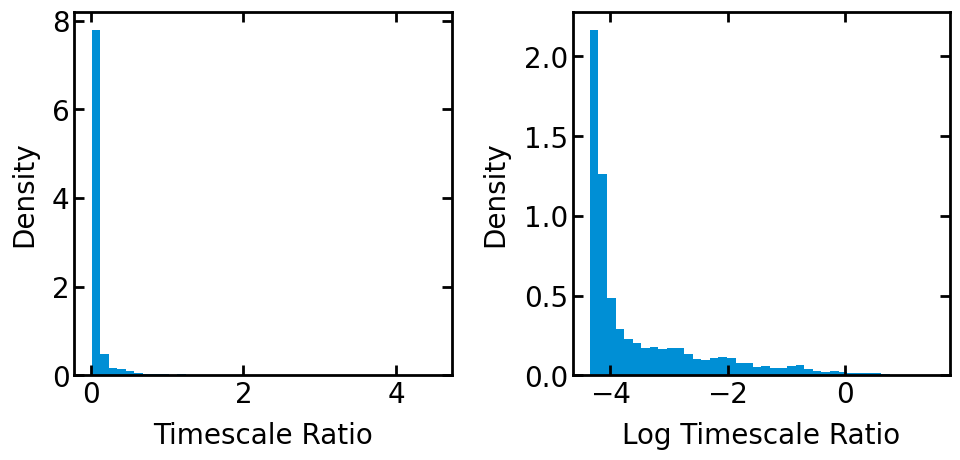

In [19]:
plt.subplot(1, 2, 1)
plt.hist(-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))])), bins=40, density=True)
plt.xlabel('Timescale Ratio')
plt.ylabel('Density')

plt.subplot(1, 2, 2)
plt.hist(np.log(-1/np.hstack(wake_rows.stability_params.apply(lambda x: x[x <= 0][:int(top_percent*len(x))]))), bins=40, density=True)
plt.xlabel('Log Timescale Ratio')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

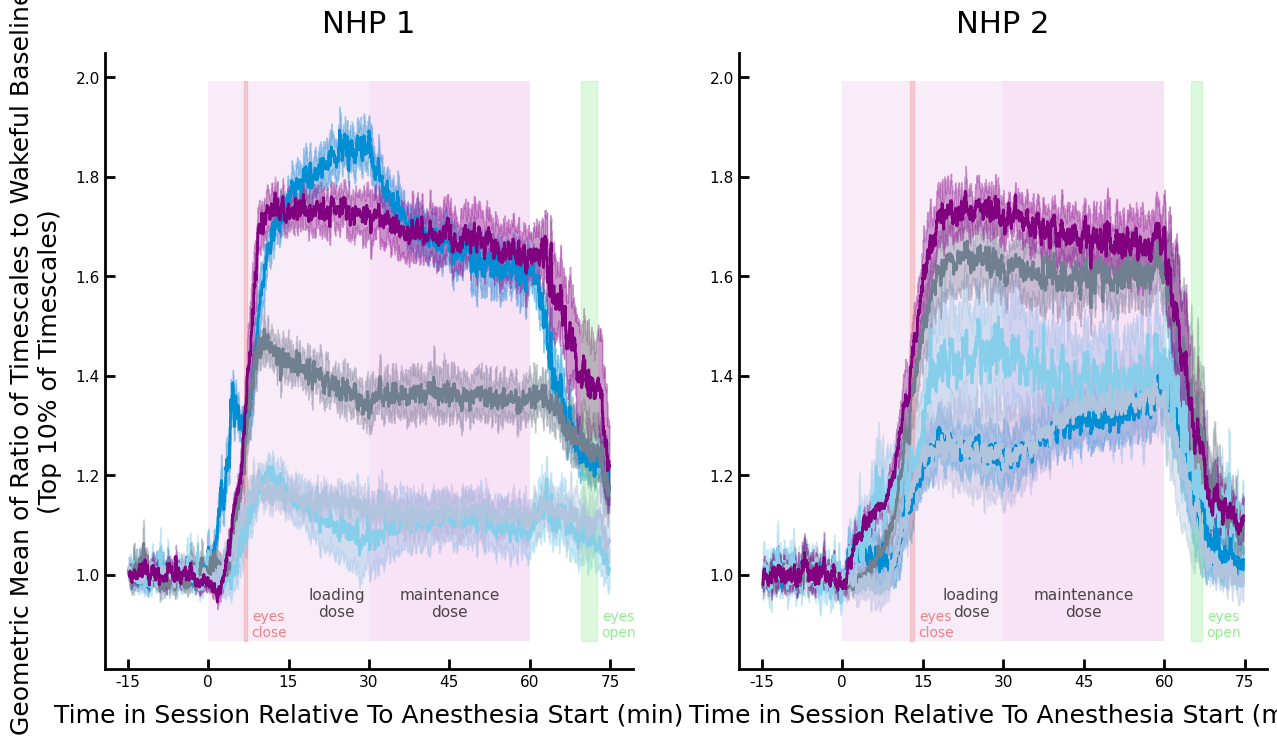

In [20]:
tick_fontsize = 11
onplot_fontsize = 14
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
plot_start_time = -15
plot_end_time = 60 + 20
time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

figure4_data['timescales'] = {}

for i, monkey in enumerate(monkeys):
    ax = axs[i]
    figure4_data['timescales'][monkey] = {}
    for j, area in enumerate(areas):

        safe_inds = counts_changes[monkey][area][time_inds].sum(axis=-1) == num_sessions[monkey]
        mean_vals = np.exp(np.log(changes_all[monkey][area][time_inds][safe_inds]).sum(axis=-1)/counts_changes[monkey][area][time_inds][safe_inds].sum(axis=-1))
        ax.plot(time_vals[time_inds][safe_inds], mean_vals, label=area_labels[area], color=area_colors[area])
        
        std_vals = np.exp(np.sqrt(np.square(np.log(changes_all[monkey][area][time_inds][safe_inds]/np.expand_dims(mean_vals, -1))).sum(axis=-1)/(counts_changes[monkey][area][time_inds][safe_inds].sum(axis=-1) - 1)))
        se_vals = np.exp(np.log(std_vals)/np.sqrt(np.sqrt(counts_changes[monkey][area][time_inds][safe_inds].sum(axis=-1))))
        lower_bound = np.exp(np.log(mean_vals) - np.log(se_vals))
        upper_bound = np.exp(np.log(mean_vals) + np.log(se_vals))
        ax.fill_between(time_vals[time_inds][safe_inds], lower_bound, upper_bound, alpha=0.4, color=area_colors[area])

        # figure4_data['timescales'][monkey][area] = {
        #     'time': time_vals[time_inds],
        #     'means': changes_all[monkey][area][time_inds],
        #     'lower_bound_se': lower_bound[time_inds],
        #     'upper_bound_se': upper_bound[time_inds]
        # }
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(labelsize=tick_fontsize)
ylim = ax.get_ylim()
for i in range(2):
    ax = axs[i]
    fill1 = ax.fill_betweenx(ylim, 0, 30, color='plum', alpha=0.2, label='infusion 1', edgecolor='none')
    fill2 = ax.fill_betweenx(ylim, 30, 60, color='orchid', alpha=0.2, label='infusion 2', edgecolor='none')
    ax.text(24, ylim[0] + 0.05, 'loading\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    ax.text(45, ylim[0] + 0.05, 'maintenance\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
    if i == 0:
        lns += plt.plot([], c=fill1.get_facecolors()[0], label=fill1.get_label())
        lns += plt.plot([], c=fill2.get_facecolors()[0], label=fill2.get_label())
    if i == 0:
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.set_ylabel(f'Geometric Mean of Ratio of Timescales to Wakeful Baseline\n(Top 10% of Timescales)', fontsize=ylabel_fontsize)
    else:
#         ax.spines[['right', 'top', 'left']].set_visible(False)
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.tick_params(axis='y', which='both', left=True, right=False)
    
    xticks = [-15, 0, 15, 30, 45, 60, 75]
    ax.set_xticks(xticks, xticks)
    ax.set_xlabel('Time in Session Relative To Anesthesia Start (min)', fontsize=xlabel_fontsize)
    ax.tick_params(labelsize=tick_fontsize)
    ax.set_title(f'NHP {i + 1}', fontsize=title_fontsize)
    
    mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
    se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_close - se_eyes_close)/60, (mean_eyes_close + se_eyes_close)/60, alpha=0.3, color='lightcoral')
    ax.text((mean_eyes_close + se_eyes_close)/60 + 4, ylim[0] + 0.01, 'eyes\nclose', color='lightcoral', fontsize=onplot_fontsize - 4, horizontalalignment='center')
    
    mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
    se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_open - se_eyes_open)/60, (mean_eyes_open + se_eyes_open)/60, alpha=0.3, color='lightgreen')
    ax.text((mean_eyes_open + se_eyes_open)/60 + 4, ylim[0] + 0.01, 'eyes\nopen', color='lightgreen', fontsize=onplot_fontsize - 4, horizontalalignment='center')

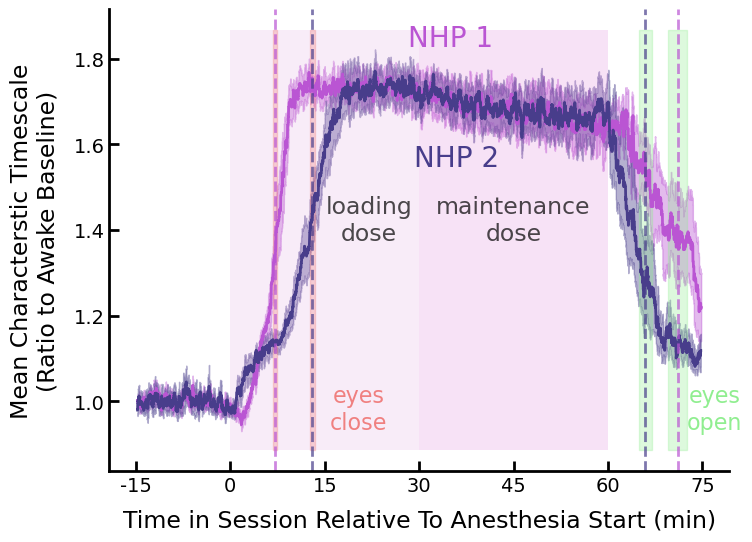

In [21]:
tick_fontsize=14
onplot_fontsize = 20
ylabel_fontsize = 17
xlabel_fontsize = 17
legend_fontsize = 16
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time
plot_start_time = -15
plot_end_time = 60 + 15
time_inds = np.logical_and(time_vals >= plot_start_time, time_vals <= plot_end_time)

fig, axs = plt.subplots(1, 1, figsize=(8, 6), sharey=True)

monkey_colors = ['mediumorchid', 'darkslateblue']
for i, monkey in enumerate(monkeys):
    ax = axs
    for j, area in enumerate(['all']):
        color = monkey_colors[i]
        safe_inds = counts_changes[monkey][area][time_inds].sum(axis=-1) == num_sessions[monkey]
        mean_vals = np.exp(np.log(changes_all[monkey][area][time_inds][safe_inds]).sum(axis=-1)/counts_changes[monkey][area][time_inds][safe_inds].sum(axis=-1))
        ax.plot(time_vals[time_inds][safe_inds], mean_vals, color=color, label=f'monkey {i + 1} all areas')
        
        std_vals = np.exp(np.sqrt(np.square(np.log(changes_all[monkey][area][time_inds][safe_inds]/np.expand_dims(mean_vals, -1))).sum(axis=-1)/(counts_changes[monkey][area][time_inds][safe_inds].sum(axis=-1) - 1)))
        se_vals = np.exp(np.log(std_vals)/np.sqrt(np.sqrt(counts_changes[monkey][area][time_inds][safe_inds].sum(axis=-1))))
        lower_bound = np.exp(np.log(mean_vals) - np.log(se_vals))
        upper_bound = np.exp(np.log(mean_vals) + np.log(se_vals))
        ax.fill_between(time_vals[time_inds][safe_inds], lower_bound, upper_bound, alpha=0.4, color=monkey_colors[i])
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(labelsize=tick_fontsize)
ylim = ax.get_ylim()
fill1 = ax.fill_betweenx(ylim, 0, 30, color='plum', alpha=0.2, edgecolor='none')
fill2 = ax.fill_betweenx(ylim, 30, 60, color='orchid', alpha=0.2, edgecolor='none')
ax.text(22, ylim[0] + (ylim[1] - ylim[0])*0.5, 'loading\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
ax.text(45, ylim[0] + (ylim[1] - ylim[0])*0.5, 'maintenance\ndose', fontsize=onplot_fontsize - 3, c='k', alpha=0.7, horizontalalignment='center',)
if i == 0:
    lns += plt.plot([], c=fill1.get_facecolors()[0], label=fill1.get_label())
    lns += plt.plot([], c=fill2.get_facecolors()[0], label=fill2.get_label())
if i == 0:
    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
else:
#         ax.spines[['right', 'top', 'left']].set_visible(False)
    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='y', which='both', left=True, right=False)
    
ax.set_ylabel(f'Mean Characterstic Timescale\n(Ratio to Awake Baseline)', fontsize=ylabel_fontsize)

xticks = [-15, 0, 15, 30, 45, 60, 75]
ax.set_xticks(xticks, xticks)
ax.set_xlabel('Time in Session Relative To Anesthesia Start (min)', fontsize=xlabel_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# ax.set_title(f'Monkey {i + 1}', fontsize=title_fontsize)
    
for i in range(2):
    mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
    se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))
    
    if i == 1:
        xshift = 7
    else:
        xshift = -4
#     ax.axvline(mean_eyes_close/60)
    ax.fill_betweenx(ylim, (mean_eyes_close - se_eyes_close)/60, (mean_eyes_close + se_eyes_close)/60, alpha=0.3, color='lightcoral')
    ax.axvline(mean_eyes_close/60, linestyle='--', color=monkey_colors[i], alpha=0.7, linewidth=2)
    if i == 1:
        ax.text((mean_eyes_close + se_eyes_close)/60 + xshift, ylim[0] + (ylim[1] - ylim[0])*0.05, 'eyes\nclose', color='lightcoral', fontsize=onplot_fontsize - 4, horizontalalignment='center')
    
    mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
    se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))
    
#     ax.axvline(mean_eyes_close/60)

    if i == 1:
        xshift = 10
    else:
        xshift = -4
    
    ax.fill_betweenx(ylim, (mean_eyes_open - se_eyes_open)/60, (mean_eyes_open + se_eyes_open)/60, alpha=0.3, color='lightgreen')
    ax.axvline(mean_eyes_open/60, linestyle='--', color=monkey_colors[i], alpha=0.7, linewidth=2)
    if i == 1:
        ax.text((mean_eyes_open + se_eyes_open)/60 + xshift, ylim[0] + (ylim[1] - ylim[0])*0.05, 'eyes\nopen', color='lightgreen', fontsize=onplot_fontsize - 4, horizontalalignment='center')
        
# ax.legend(fontsize=legend_fontsize, loc='upper left', bbox_to_anchor=(0.95, 1))
ax.text(35, 1.83, "NHP 1", color=monkey_colors[0], ha='center', fontsize=onplot_fontsize)
ax.text(36, 1.55, "NHP 2", color=monkey_colors[1], ha='center', fontsize=onplot_fontsize)
plt.savefig(os.path.join(img_save_dir, "main", "stability-timescales.pdf"), bbox_inches='tight', transparent=True)
plt.show()

# Figure 5c

In [22]:
top_percent = 0.1

In [23]:
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time

In [41]:
max_vals = {}
min_vals = {}
for monkey in monkeys:
    max_vals[monkey] = {}
    min_vals[monkey] = {}
    for session in session_dicts[monkey].keys():
        for area in session_dicts[monkey][session]['results_dict'].keys():
            all_vals = np.hstack(session_dicts[monkey][session]['results_dict'][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))]))
            max_val = np.max(all_vals)
            min_val = np.min(all_vals)
            if area in max_vals[monkey]:
                if max_val > max_vals[monkey][area]:
                    max_vals[monkey][area] = max_val
                if min_val < min_vals[monkey][area]:
                    min_vals[monkey][area] = min_val
            else:
                max_vals[monkey][area] = max_val
                min_vals[monkey][area] = min_val
        

In [43]:
# compute means
# compute standard error
total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += np.sum(np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60))
        
iterator = tqdm(total=total_its)

density = True
log_density = False
bin_nums = 20

criticality_prob_dists = {}
counts_dist = {}
bins_all = {}
# mean_stab_all = {}
# se_all = {}

for monkey in monkeys:
    criticality_prob_dists[monkey] = {}
    counts_dist[monkey] = {}
    bins_all[monkey] = {}
#     mean_stab_all[monkey] = {}
#     se_all[monkey] = {}
    for area in stability_all[monkey].keys():
        criticality_prob_dists[monkey][area] = np.zeros((len(time_vals), bin_nums))
        counts_dist[monkey][area] = np.zeros(criticality_prob_dists[monkey][area].shape)
        emin = min_vals[monkey][area]
        emax = max_vals[monkey][area]
        # emax = np.max([mean_stab_all[monkey][area][section][0] + 0.5*np.sqrt(se_counts_all[monkey][area][section])*se_all[monkey][area][section][0] for section in sections])
        # emin = np.min([mean_stab_all[monkey][area][section][-1] - 0.5*np.sqrt(se_counts_all[monkey][area][section])*se_all[monkey][area][section][-1] for section in sections])
        bins = [(emax - emin)*i/bin_nums + emin for i in range(bin_nums + 1 )]
        bins_all[monkey][area] = bins
        for session, session_dict in session_rets.items():
            if len(monkeys) == 1 or monkey in session:
                filter_inds = np.logical_and(session_dict['results_dict'][area].start_time >= session_dict['session_info']['drugStart'][0] - leadup_time*60, session_dict['results_dict'][area].end_time <= session_dict['session_info']['drugEnd'][1] + post_time*60)
                for i, row in session_dict['results_dict'][area][filter_inds].iterrows():
                    start_ind = int(leadup_time*60/dt_stab) - int((session_dict['session_info']['drugStart'][0] - row.start_time)/dt_stab)
                    end_ind = start_ind + int((row.end_time - row.start_time)/dt_stab)
                    hist_vals  = np.histogram(row.stability_params[:int(top_percent*len(row.stability_params))], bins=bins, density=density)[0]
                    if log_density:
                        hist_vals = [np.log(d) for d in np.histogram(stab_params.iloc[t], bins=bins, density=density)[0] if d > 0]
                    criticality_prob_dists[monkey][area][start_ind:end_ind] += hist_vals
                    counts_dist[monkey][area][start_ind:end_ind] += 1
                    iterator.update()
        
        counts_safe = counts_dist[monkey][area].copy()
        criticality_prob_dists[monkey][area][counts_safe > 0] /= counts_safe[counts_safe > 0]

iterator.close()

  0%|          | 0/37710 [00:00<?, ?it/s]

In [44]:
eyes_closes = {}
eyes_opens = {}
for monkey in monkeys:
    eyes_closes[monkey] = []
    eyes_opens[monkey] = []
    for session, session_dict in session_rets.items():
        if len(monkey) == 1 or monkey in session:
            
            eyes_closes[monkey].append(session_dict['eyes_close'] - session_dict['session_info']['drugStart'][0])
            eyes_opens[monkey].append(session_dict['eyes_open']  - session_dict['session_info']['drugStart'][0])

In [45]:
figure4_data['stability_prob_dist'] = criticality_prob_dists

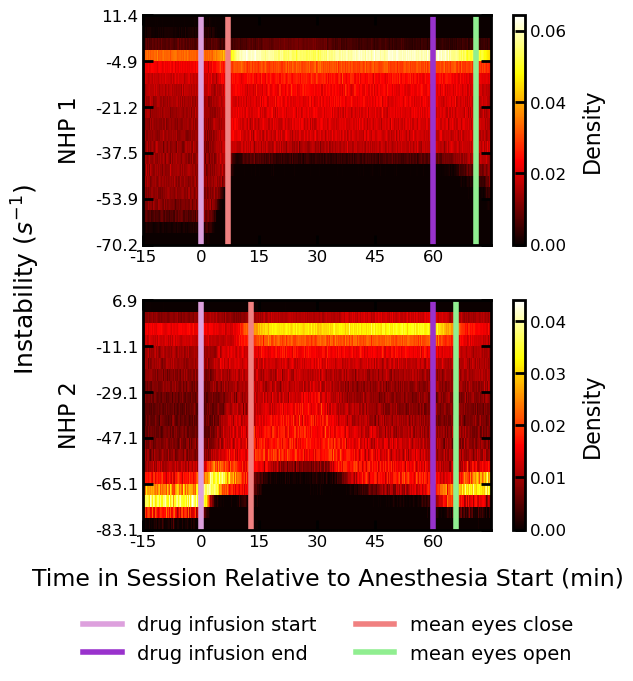

In [47]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
ytick_fontsize=12
xtick_fontsize=12
title_fontsize = 18
ylabel_fontsize=18
xlabel_fontsize=17
cbarlabel_fontsize=16
cbarticks_fontsize=12
legend_fontsize=14

linewidth = 4

for i, monkey in enumerate(monkeys):
    
    mean_eyes_close = np.mean(eyes_closes[monkeys[i]])
#     se_eyes_close = np.std(eyes_closes[monkeys[i]])/np.sqrt(len(eyes_closes[monkeys[i]]))
    
    mean_eyes_open = np.mean(eyes_opens[monkeys[i]])
#     se_eyes_open = np.std(eyes_opens[monkeys[i]])/np.sqrt(len(eyes_opens[monkeys[i]]))
    
#     for j, area in enumerate(areas):
    for j, area in enumerate(['all']):
        ax = axs[i]
        im = ax.pcolormesh(criticality_prob_dists[monkey][area].T, cmap='hot')
        ax.set_yticks(np.arange(0, bin_nums + 1, 4))
        ax.set_yticklabels([f"{b:.1f}" for b in np.array(bins_all[monkey][area])[np.arange(0, bin_nums + 1, 4)]], fontsize=ytick_fontsize)
        x_step = 15 # mins
        xtick_locs = np.arange(0, int(criticality_prob_dists[monkey][area].shape[0]), x_step*60/dt_stab)
        ax.set_xticks(xtick_locs)
        ax.set_xticklabels([int(loc*dt_stab/60) - 15 for loc in xtick_locs], fontsize=xtick_fontsize)
        
        if j == 0:
            ax.set_ylabel(f'NHP {i + 1}', fontsize=ylabel_fontsize - 2)
#         if i == 0:
#             ax.set_title(area_labels[area], c=area_colors[area], fontsize=title_fontsize)
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(label='Density', fontsize=cbarlabel_fontsize)
        cbar.ax.tick_params(labelsize=cbarticks_fontsize)
#         cbar.set_label('Stability Density' if density else '# Modes', fontsize=cbarlabel_fontsize)

        lns = []
        lns.append(ax.axvline((0 + 15)*60/dt_stab, color='plum', label=f"drug infusion start", linewidth=linewidth))
        lns.append(ax.axvline((60 + 15)*60/dt_stab, color='darkorchid', label='drug infusion end', linewidth=linewidth))
        lns.append(ax.axvline((mean_eyes_close + 15*60)/dt_stab, color='lightcoral', label=f"mean eyes close", linewidth=linewidth))
        lns.append(ax.axvline((mean_eyes_open + 15*60)/dt_stab, color='lightgreen', label=f"mean eyes open", linewidth=linewidth))

fig.text(0.5, -0.01, 'Time in Session Relative to Anesthesia Start (min)', ha='center', fontsize=xlabel_fontsize)
fig.text(-0.03, 0.5, 'Instability ' + r'($s^{-1}$)', va='center', rotation='vertical', fontsize=ylabel_fontsize)
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.1), loc='center', ncol=2, fontsize=legend_fontsize)
plt.tight_layout()
# plt.savefig(os.path.join(img_save_dir, "main", "densities.pdf"), bbox_inches='tight', transparent=True)
plt.show()

# Figure 5d

In [48]:
top_percent = 0.1

In [49]:
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time

In [112]:
# compute means
# compute standard error

section_info = [('awake', [-15, 0]), ('unconscious', [15, 60]), ('recovery', [75, 85])]

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += len(section_info)
        
iterator = tqdm(total=total_its)


# se_counts_all = {}
# mean_stab_all = {}
stability_spectrums = {}
freq_spectrums = {}
# se_all = {}

for monkey in monkeys:
    stability_spectrums[monkey] = {}
    freq_spectrums[monkey] = {}
    for area in stability_all[monkey].keys():
        num_elems = np.min([np.min(session_dicts[monkey][session]['results_dict'][area].stability_params.apply(lambda x: int(top_percent*len(x)))) for session in session_dicts[monkey].keys()])
        stability_spectrums[monkey][area] = {}
        freq_spectrums[monkey][area] = {}
        for section, bounds in section_info:
            stability_spectrums[monkey][area][section] = np.zeros((num_sessions[monkey], num_elems))
            freq_spectrums[monkey][area][section] = np.zeros((num_sessions[monkey], num_elems))
            for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
                filter_inds = ((session_dict['results_dict'][area].start_time - session_dict['session_info']['drugStart'][0])/60 >= bounds[0]) & ((session_dict['results_dict'][area].start_time - session_dict['session_info']['drugStart'][0])/60 <= bounds[1])
                stability_spectrums[monkey][area][section][session_ind] = np.vstack(session_dict['results_dict'][area][filter_inds].stability_params.apply(lambda x: x[:num_elems])).mean(axis=0)
                freq_spectrums[monkey][area][section][session_ind] = np.vstack(session_dict['results_dict'][area][filter_inds].stability_freqs.apply(lambda x: x[:num_elems])).mean(axis=0)

                iterator.update()
           
iterator.close()

figure4_data['section_stability'] = dict(
    stability_spectrums=stability_spectrums,
    freq_spectrums=freq_spectrums
)

  0%|          | 0/315 [00:00<?, ?it/s]

In [113]:
monkey = 'Mary'
area = 'vlPFC'
sections = ['awake', 'unconscious', 'recovery']

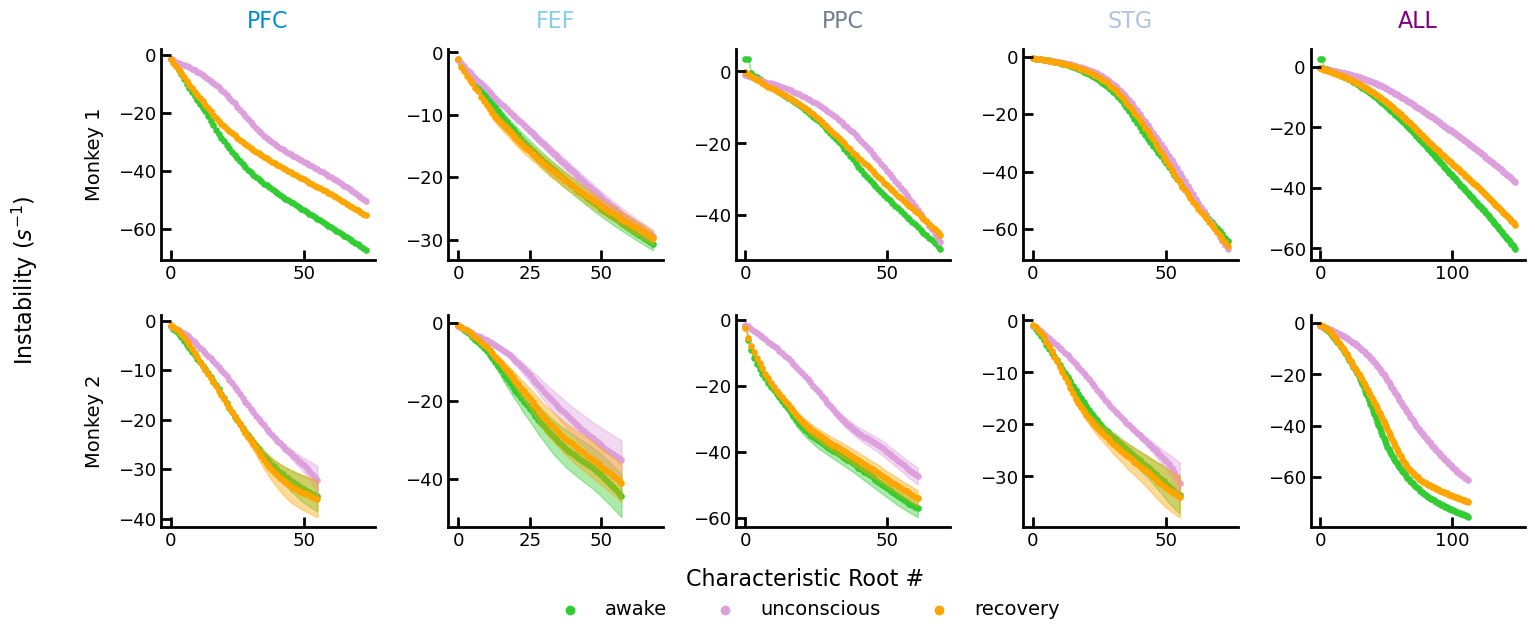

In [114]:
title_fontsize = 16
ylabel_fontsize=16
xlabel_fontsize=16
tick_fontsize=13
legend_fontsize=14
s=14
# fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey=True, sharex=True)
fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharey=False, sharex='col')
lns = []
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(areas):
        ax = axs[i][j]
        for section in sections:
            mean_vals = stability_spectrums[monkey][area][section].mean(axis=0)
            se_vals = stability_spectrums[monkey][area][section].std(axis=0)/np.sqrt(stability_spectrums[monkey][area][section].shape[0])
            ax.scatter(np.arange(len(mean_vals)), mean_vals, c=section_colors[section], label=section, s=s)
            if i == 0 and j == 0:
                scatter = ax.scatter([], [], c=section_colors[section], label=section)
                lns.append(scatter)
            ax.fill_between(np.arange(len(mean_vals)), mean_vals - se_vals, mean_vals + se_vals, color=section_colors[section], alpha=0.4)
            
            ax.spines[['right', 'top']].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            ax.tick_params(labelsize=tick_fontsize)
#             ax.set_xlabel('Characteristic Root #', fontsize=xlabel_fontsize)
            
            if i == 0:
                ax.set_title(area_labels[area], c=area_colors[area], fontsize=title_fontsize)
            if j == 0:
#                 ax.set_ylabel(f'Monkey {i + 1}\nInstability ' + r'($\frac{mV}{s}$)', fontsize=ylabel_fontsize)
                ax.set_ylabel(f'Monkey {i + 1}', fontsize=ylabel_fontsize- 2)
            
#             if j == 0:
#                 if i == 0:
#                     ax.spines[['right', 'top', 'bottom']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=False)
#                     ax.yaxis.set_ticks_position('left')
#                 else:
#                     ax.spines[['right', 'top']].set_visible(False)
#                     ax.xaxis.set_ticks_position('bottom')
#                     ax.yaxis.set_ticks_position('left')
#             else:
#                 if i == 0:
#                     ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=False)
#                     ax.tick_params(axis='y', which='both', right=False, left=False)
#                 else:
#                     ax.spines[['right', 'top', 'left']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=True)
#                     ax.tick_params(axis='y', which='both', right=False, left=False)
fig.text(0.5, -0.01, 'Characteristic Root #', ha='center', fontsize=xlabel_fontsize)
fig.text(-0.03, 0.5, 'Instability ' + r'($s^{-1}$)', va='center', rotation='vertical', fontsize=ylabel_fontsize)
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=3, fontsize=legend_fontsize)
plt.tight_layout()
plt.show()

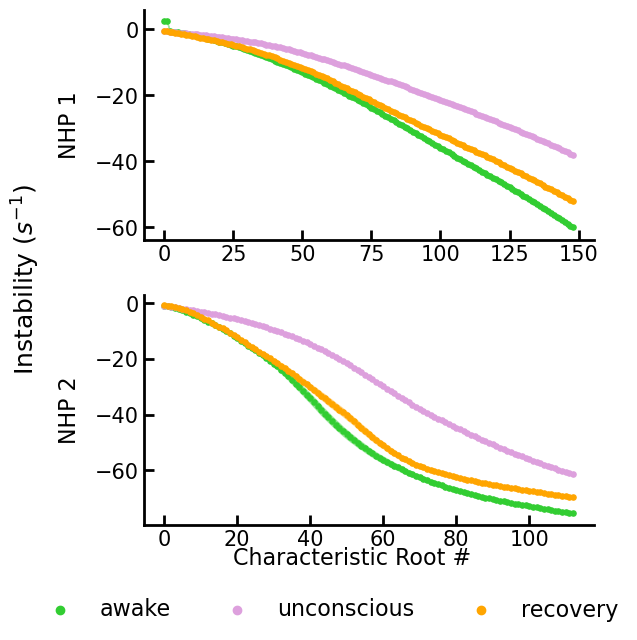

In [115]:
title_fontsize = 18
ylabel_fontsize=18
xlabel_fontsize=18
tick_fontsize=15
legend_fontsize=16
s=14
# fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey=True, sharex=True)
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharey=False, sharex=False)
lns = []
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(['all']):
#         ax = axs[i][j]
        ax = axs[i]
        for section in sections:
            mean_vals = stability_spectrums[monkey][area][section].mean(axis=0)
            se_vals = stability_spectrums[monkey][area][section].std(axis=0)/np.sqrt(stability_spectrums[monkey][area][section].shape[0])
            ax.scatter(np.arange(len(mean_vals)), mean_vals, c=section_colors[section], label=section, s=s)
            if i == 0 and j == 0:
                scatter = ax.scatter([], [], c=section_colors[section], label=section)
                lns.append(scatter)
            ax.fill_between(np.arange(len(mean_vals)), mean_vals - se_vals, mean_vals + se_vals, color=section_colors[section], alpha=0.4)
            
            ax.spines[['right', 'top']].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            ax.tick_params(labelsize=tick_fontsize)
#             ax.set_xlabel('Characteristic Root #', fontsize=xlabel_fontsize)
            
            if i == 0:
                pass
#                 ax.set_title(area_labels[area], c=area_colors[area], fontsize=title_fontsize)
            if j == 0:
#                 ax.set_ylabel(f'Monkey {i + 1}\nInstability ' + r'($\frac{mV}{s}$)', fontsize=ylabel_fontsize)
                ax.set_ylabel(f'NHP {i + 1}', fontsize=ylabel_fontsize- 2)
            
#             if j == 0:
#                 if i == 0:
#                     ax.spines[['right', 'top', 'bottom']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=False)
#                     ax.yaxis.set_ticks_position('left')
#                 else:
#                     ax.spines[['right', 'top']].set_visible(False)
#                     ax.xaxis.set_ticks_position('bottom')
#                     ax.yaxis.set_ticks_position('left')
#             else:
#                 if i == 0:
#                     ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=False)
#                     ax.tick_params(axis='y', which='both', right=False, left=False)
#                 else:
#                     ax.spines[['right', 'top', 'left']].set_visible(False)
#                     ax.tick_params(axis='x', which='both', top=False, bottom=True)
#                     ax.tick_params(axis='y', which='both', right=False, left=False)
fig.text(0.54, -0.02, f'Characteristic Root #\n', ha='center', fontsize=xlabel_fontsize - 2)
fig.text(-0.03, 0.5, 'Instability ' + r'($s^{-1}$)', va='center', rotation='vertical', fontsize=ylabel_fontsize)
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=3, fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, "main", "spectrum.pdf"), bbox_inches='tight', transparent=True)
plt.show()

# Figure S2b

In [ ]:
top_percent = 0.1

section_info = [('awake', [-15, 0]), ('unconscious', [15, 60]), ('recovery', [75, 85]), ('loading dose', [20, 30]), ('maintenance dose', [50, 60])]

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += len(section_info)
        
iterator = tqdm(total=total_its)

stab_means = {}
for monkey in monkeys:
    stab_means[monkey] = {}
    for area in stability_all[monkey].keys():
        stab_means[monkey][area] = {}
        for section, bounds in section_info:
            stab_means[monkey][area][section] = np.zeros(num_sessions[monkey])
            for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
                df = session_dict['results_dict'][area]
                filter_inds = ((df.start_time - session_dict['session_info']['drugStart'][0])/60 >= bounds[0]) & ((df.start_time - session_dict['session_info']['drugStart'][0])/60 <= bounds[1])
                stab_means[monkey][area][section][session_ind] = np.hstack(df[filter_inds].stability_params.apply(lambda x: x[:int(top_percent*len(x))])).mean()
                iterator.update()
iterator.close()

In [91]:
section_info = [('wake', [-15, 0]), ('anesthesia', [15, 60])]
# top_percents = [0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.45, 0.45, 0.5]
# d_percent = 0.01
# top_percents = np.arange(d_percent, 0.5 + d_percent/2, d_percent)
top_percents = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
top_percents = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3]

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += len(top_percents)*len(section_info)
        
iterator = tqdm(total=total_its)

# all_vals = {}
mannwhitney_rets = {}
stab_means = {}
for monkey in monkeys:
    stab_means[monkey] = {}
    mannwhitney_rets[monkey] = {}
    for area in stability_all[monkey].keys():
        stab_means[monkey][area] = {}
        mannwhitney_rets[monkey][area] = {}
        for tp_ind, top_percent in enumerate(top_percents):
            for section, bounds in section_info:
                stab_means[monkey][area][section] = np.zeros(num_sessions[monkey])
                for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
                    df = session_dict['results_dict'][area]
                    filter_inds = ((df.start_time - session_dict['session_info']['drugStart'][0])/60 >= bounds[0]) & ((df.start_time - session_dict['session_info']['drugStart'][0])/60 <= bounds[1])
                    stab_means[monkey][area][section][session_ind] = np.hstack(df[filter_inds].stability_params.apply(lambda x: x[:int(top_percent*len(x))])).mean()
                    iterator.update()

            stat, p = scipy.stats.mannwhitneyu(stab_means[monkey][area]['wake'],stab_means[monkey][area]['anesthesia'], alternative='less')
            mannwhitney_rets[monkey][area][top_percent] = {'stat': stat, 'p': p}
            
iterator.close()

  0%|          | 0/2520 [00:00<?, ?it/s]

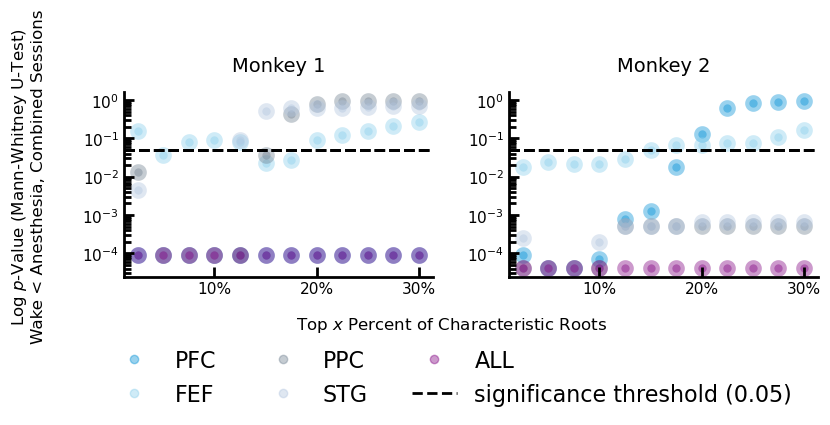

In [103]:
tick_fontsize=11
xlabel_fontsize=12
ylabel_fontsize=12
title_fontsize = 14
linewidth=6
# fig, axs = plt.subplots(2, 4, figsize=(12, 5), sharex=True, sharey=True)
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
s = 7

for i, monkey in enumerate(monkeys):
    ax = axs[i]
    for j, area in enumerate(areas):
#         ax = axs[i][j]
#         ax.bar(list(mannwhitney_rets[monkey][area].keys()), [value['p'] for value in mannwhitney_rets[monkey][area].values()], alpha=0.7, width=top_percents[1] - top_percents[0])
#         ax.scatter(list(mannwhitney_rets[monkey][area].keys()), [value['p'] for value in mannwhitney_rets[monkey][area].values()], alpha=0.7, s=s, color=area_colors[area])
        ax.scatter(np.array(list(mannwhitney_rets[monkey][area].keys()))*100, [value['p'] for value in mannwhitney_rets[monkey][area].values()], alpha=0.4, color=area_colors[area], linewidth=linewidth)
        ax.set_xticks(np.arange(0, 31, 10))
        ax.set_xticklabels([f"{i}%" for i in np.arange(0, 31, 10)])
        ax.set_title(f"Monkey {i + 1}", fontsize=title_fontsize)
        ax.set_yscale('log')
        ax.axhline(0.05, linestyle='--', c='k')
        
        ax.spines[['right', 'top']].set_visible(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        ax.tick_params(labelsize=tick_fontsize)

lns = []
for area in areas:
    lns += ax.plot([], [], 'o', alpha=0.4, label=area_labels[area], color=area_colors[area], linewidth=linewidth)
lns += ax.plot([], [], linestyle='--', c='k', label='significance threshold (0.05)')

fig.legend(lns, [ln.get_label() for ln in lns], fontsize=legend_fontsize, bbox_to_anchor=(0.5, -0.17), loc='center', ncol=3)
fig.text(0.5, -0.01, 'Top $x$ Percent of Characteristic Roots', ha='center', fontsize=xlabel_fontsize)
fig.text(-0.03, 0.5, 'Log $p$-Value (Mann-Whitney U-Test)\nWake < Anesthesia, Combined Sessions', va='center', ha='center', rotation='vertical', fontsize=ylabel_fontsize)
plt.tight_layout()
plt.show()

# Figure 5e

In [104]:
top_percent = 0.1

In [105]:
time_vals = np.arange(int((leadup_time + 60 + post_time)*60*(1/dt_stab)))*dt_stab/60 - leadup_time

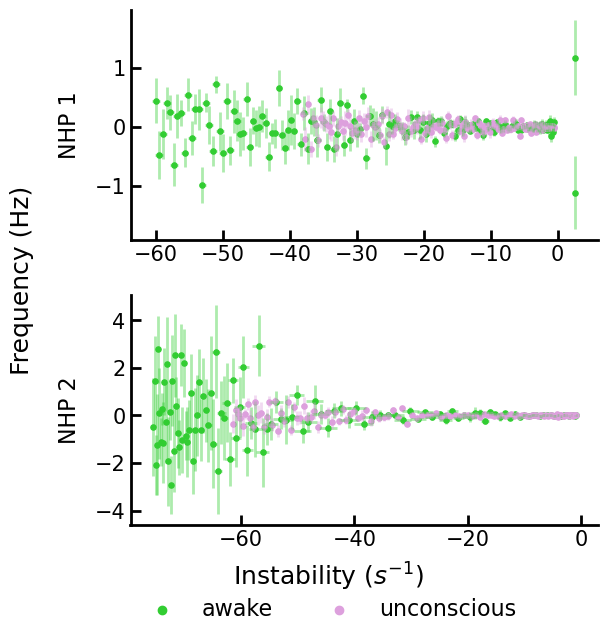

In [120]:
title_fontsize = 18
ylabel_fontsize=18
xlabel_fontsize=18
tick_fontsize=15
legend_fontsize=16
s=14
# fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharey=True, sharex=True)
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharey=False, sharex=False)
lns = []
for i, monkey in enumerate(monkeys):
    for j, area in enumerate(['all']):
        ax = axs[i]
        for section in ['awake', 'unconscious']:
            mean_vals = stability_spectrums[monkey][area][section].mean(axis=0)
            stab_se_vals = stability_spectrums[monkey][area][section].std(axis=0)/np.sqrt(stability_spectrums[monkey][area][section].shape[0])
            mean_freqs = freq_spectrums[monkey][area][section].mean(axis=0)
            freq_se_vals = freq_spectrums[monkey][area][section].std(axis=0)/np.sqrt(freq_spectrums[monkey][area][section].shape[0])
            ax.scatter(mean_vals, mean_freqs, c=section_colors[section], label=section, s=s)
            if i == 0 and j == 0:
                scatter = ax.scatter([], [], c=section_colors[section], label=section)
                lns.append(scatter)
#             ax.fill_between(np.arange(len(mean_vals)), mean_vals - se_all[monkey][area][section], mean_vals + se_all[monkey][area][section], color=section_colors[section], alpha=0.4)
            ax.errorbar(mean_vals, mean_freqs, xerr=stab_se_vals, yerr=freq_se_vals, color=section_colors[section], alpha=0.4, linestyle="None")
            
            ax.spines[['right', 'top']].set_visible(False)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            ax.tick_params(labelsize=tick_fontsize)
            if j == 0:
                ax.set_ylabel(f'NHP {i + 1}', fontsize=ylabel_fontsize- 2)
            
fig.text(0.5, -0.01, 'Instability ' + r'($s^{-1}$)', ha='center', fontsize=xlabel_fontsize)
fig.text(-0.03, 0.5, 'Frequency (Hz)', va='center', rotation='vertical', fontsize=ylabel_fontsize)
labs = [ln.get_label() for ln in lns]
fig.legend(lns, labs, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=3, fontsize=legend_fontsize)
plt.tight_layout()
plt.savefig(os.path.join(img_save_dir, "main", "frequencies.pdf"), bbox_inches='tight', transparent=True)
plt.show()

# Statistics (Figure S2c)

## Statistical Analysis of Frequencies

In [121]:
bands = {
    'delta': [0.5, 4],
    'theta': [4, 8],
    'alpha': [8, 12],
    'beta': [12, 30],
    'gamma': [30, 80],
    'high gamma': [80, np.Inf]
}

In [122]:
top_percent = 0.1

section_info = [('awake', [-15, 0]), ('unconscious', [15, 60]), ('recovery', [75, 85]), ('loading dose', [20, 30]), ('maintenance dose', [50, 60])]

total_its = 0
area_comps = ['all']
for area in area_comps:
    for session, session_dict in session_rets.items():
        total_its += len(section_info)*len(bands)
        
iterator = tqdm(total=total_its)

freq_props = {}
for monkey in monkeys:
    freq_props[monkey] = {}
    for area in area_comps:
        freq_props[monkey][area] = {}
        for section, bounds in section_info:
            freq_props[monkey][area][section] = {}
            for band, band_bounds in bands.items():
                freq_props[monkey][area][section][band] = np.zeros(num_sessions[monkey])
                for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
                    df = session_dict['results_dict'][area]
                    filter_inds = ((df.start_time - session_dict['session_info']['drugStart'][0])/60 >= bounds[0]) & ((df.start_time - session_dict['session_info']['drugStart'][0])/60 <= bounds[1])
                    all_freqs = np.abs(np.hstack(df[filter_inds].stability_freqs.apply(lambda x: x[:int(top_percent*len(x))])))
                    min_freq, max_freq = band_bounds
                    band_freqs = all_freqs[(all_freqs >= min_freq) & (all_freqs <= max_freq)]
                    freq_props[monkey][area][section][band][session_ind] = len(band_freqs)/len(all_freqs)
                    iterator.update()
iterator.close()

  0%|          | 0/630 [00:00<?, ?it/s]

In [123]:
from matplotlib.patches import Rectangle

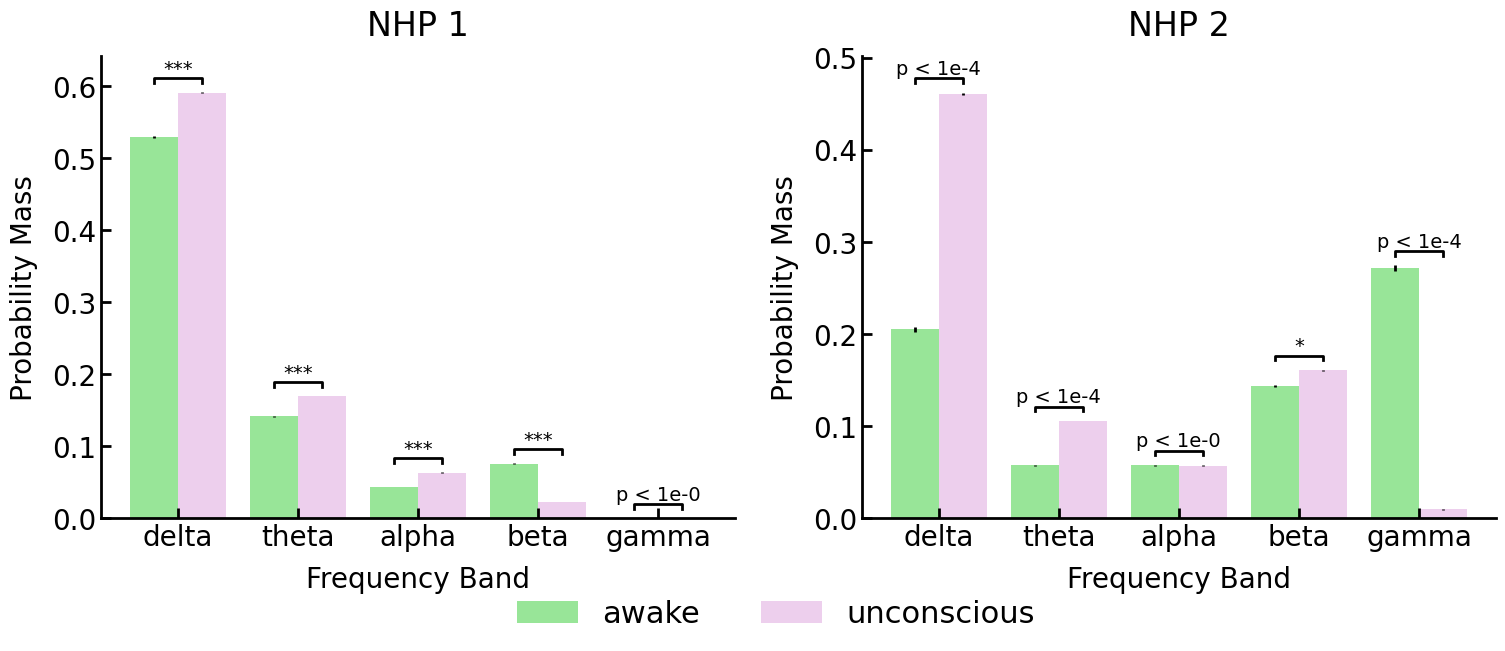

In [124]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

for i, monkey in enumerate(monkeys):
    ax = axs[i]
    bands_to_plot = [band for band in list(bands.keys()) if band != 'high gamma']
    mean_vals_awake = [freq_props[monkey]['all']['awake'][band].mean() for band in bands_to_plot]
    err_vals_awake = [freq_props[monkey]['all']['awake'][band].std()/len(freq_props[monkey]['all']['awake'][band]) for band in bands_to_plot]
    mean_vals_unconscious = [freq_props[monkey]['all']['unconscious'][band].mean() for band in bands_to_plot]
    err_vals_unconscious = [freq_props[monkey]['all']['unconscious'][band].std()/len(freq_props[monkey]['all']['awake'][band]) for band in bands_to_plot]
    ax.bar(np.arange(len(bands_to_plot))*2 - 0.4, mean_vals_awake, color=section_colors['awake'], alpha=0.5, yerr=err_vals_awake)
    ax.bar(np.arange(len(bands_to_plot))*2 + 0.4, mean_vals_unconscious, color=section_colors['unconscious'], alpha=0.5, yerr=err_vals_unconscious)
    ax.set_xticks(np.arange(len(bands_to_plot))*2)
    ax.set_xticklabels(bands_to_plot)
    dh = 0.02
    gap = 0.02
    barh = 0.01
    p_fontsize = 14
    for j, band in enumerate(bands_to_plot):
        p = scipy.stats.mannwhitneyu(freq_props[monkey][area]['awake'][band], freq_props[monkey][area]['unconscious'][band]).pvalue
        barplot_annotate_brackets(0, 1, p, [j*2 - 0.4, j*2 + 0.4], [mean_vals_awake[j], mean_vals_unconscious[j]], yerr=[err_vals_awake[j], err_vals_unconscious[j]], scale_by_height=False, ax=ax, it=0, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=False)
    
    # ax.set_yscale('log')
    ax.spines[['right', 'top']].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_title(f'NHP {i + 1}')
    ax.set_ylabel('Probability Mass')
    ax.set_xlabel('Frequency Band')

legend_fontsize=22
handles = [Rectangle((0,0),1,1,color=section_colors[section],alpha=0.5, ec='none') for section in ['awake', 'unconscious']]
labels= ['awake', 'unconscious']
fig.legend(handles, labels, bbox_to_anchor=(0.5, -0.05), loc='center', ncol=3, fontsize=legend_fontsize)


plt.show()

## Statistic Analysis of Stability

### Propofol reliably destabilized neural dynamics

In [125]:
top_percent = 0.1

section_info = [('awake', [-15, 0]), ('unconscious', [15, 60]), ('recovery', [75, 85]), ('loading dose', [20, 30]), ('maintenance dose', [50, 60])]

total_its = 0
for area in areas:
    for session, session_dict in session_rets.items():
        total_its += len(section_info)
        
iterator = tqdm(total=total_its)

stab_means = {}
for monkey in monkeys:
    stab_means[monkey] = {}
    for area in stability_all[monkey].keys():
        stab_means[monkey][area] = {}
        for section, bounds in section_info:
            stab_means[monkey][area][section] = np.zeros(num_sessions[monkey])
            for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
                df = session_dict['results_dict'][area]
                filter_inds = ((df.start_time - session_dict['session_info']['drugStart'][0])/60 >= bounds[0]) & ((df.start_time - session_dict['session_info']['drugStart'][0])/60 <= bounds[1])
                stab_means[monkey][area][section][session_ind] = np.hstack(df[filter_inds].stability_params.apply(lambda x: x[:int(top_percent*len(x))])).mean()
                iterator.update()
iterator.close()

  0%|          | 0/525 [00:00<?, ?it/s]

In [126]:
for monkey in stab_means.keys():
    for area in stab_means[monkey].keys():
        res = scipy.stats.mannwhitneyu(stab_means[monkey][area]['awake'], stab_means[monkey][area]['unconscious'], alternative='less')
        print(f"{monkey}, {area}: {res} | n_wake = {len(stab_means[monkey][area]['awake'])}, n_unconscious = {len(stab_means[monkey][area]['unconscious'])}")

Mary, vlPFC: MannwhitneyuResult(statistic=0.0, pvalue=9.133589555477501e-05) | n_wake = 10, n_unconscious = 10
Mary, FEF: MannwhitneyuResult(statistic=32.0, pvalue=0.09293836618293788) | n_wake = 10, n_unconscious = 10
Mary, 7b: MannwhitneyuResult(statistic=0.0, pvalue=9.133589555477501e-05) | n_wake = 10, n_unconscious = 10
Mary, CPB: MannwhitneyuResult(statistic=0.0, pvalue=9.133589555477501e-05) | n_wake = 10, n_unconscious = 10
Mary, all: MannwhitneyuResult(statistic=0.0, pvalue=9.133589555477501e-05) | n_wake = 10, n_unconscious = 10
MrJones, vlPFC: MannwhitneyuResult(statistic=2.0, pvalue=6.988621323179198e-05) | n_wake = 11, n_unconscious = 11
MrJones, FEF: MannwhitneyuResult(statistic=29.0, pvalue=0.020894498401492264) | n_wake = 11, n_unconscious = 11
MrJones, 7b: MannwhitneyuResult(statistic=0.0, pvalue=4.075768063871622e-05) | n_wake = 11, n_unconscious = 11
MrJones, CPB: MannwhitneyuResult(statistic=6.0, pvalue=0.00019562947333559878) | n_wake = 11, n_unconscious = 11
MrJon

### The destabilization was dose dependent

In [127]:
for monkey in stab_means.keys():
    # for area in stab_means[monkey].keys():
    for area in ['all']:
        res = scipy.stats.mannwhitneyu(stab_means[monkey][area]['maintenance dose'], stab_means[monkey][area]['loading dose'], alternative='less')
        print(f"{monkey}, {area}: {res} | n_wake = {len(stab_means[monkey][area]['maintenance dose'])}, n_unconscious = {len(stab_means[monkey][area]['loading dose'])}")

Mary, all: MannwhitneyuResult(statistic=23.0, pvalue=0.022577284812139504) | n_wake = 10, n_unconscious = 10
MrJones, all: MannwhitneyuResult(statistic=1.0, pvalue=5.347994134279083e-05) | n_wake = 11, n_unconscious = 11


In [128]:
# fig, axs = plt.subplots(1, 2, figsize=(14, 6))
# color_list = ['plum', 'orchid']
# for i, monkey in enumerate(stab_means.keys()):
#     for area in ['all']:
#         doses = ['loading dose', 'maintenance dose']
#         mean_vals = [stab_means[monkey][area][dose].mean() for dose in doses]
#         err_vals = [stab_means[monkey][area][dose].std()/np.sqrt(len(stab_means[monkey][area][dose])) for dose in doses]
#         axs[i].bar(doses, mean_vals, yerr=err_vals, color=color_list)
#         ylim = axs[i].get_ylim()
#         axs[i].set_ylim([ylim[0], (np.max(mean_vals) + np.max(err_vals))*0.9])
#         axs[i].set_title(f"NHP {i + 1}")
#         axs[i].set_ylabel(f'Instability ' + r'($s^{-1}$)')

#         axs[i].spines[['right', 'top']].set_visible(False)
#         axs[i].xaxis.set_ticks_position('bottom')
#         axs[i].tick_params(axis='y', which='both', left=True, right=False)

#         dh = 0.1
#         gap = 0.6
#         barh = 0.1
#         p_fontsize=14
#         p = scipy.stats.mannwhitneyu(stab_means[monkey][area]['maintenance dose'], stab_means[monkey][area]['loading dose'], alternative='less').pvalue
#         barplot_annotate_brackets(0, 1, p, [0, 1], mean_vals, yerr=err_vals, scale_by_height=True, ax=axs[i], it=0, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=True)

# plt.tight_layout()

In [147]:
dosages = {}
dosage_data = {}
for monkey in stab_means.keys():
    dosages[monkey] = np.zeros((num_sessions[monkey], 3))
    dosage_data[monkey] = np.zeros((num_sessions[monkey], 3))
    for area in ['all']:
        for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
            dosages[monkey][session_ind, 0] = 0
            dosage_data[monkey][session_ind, 0] = stab_means[monkey][area]['awake'][session_ind]
            
            dosages[monkey][session_ind, 1] = session_dict['session_info']['drugDose'][0]
            dosage_data[monkey][session_ind, 1] = stab_means[monkey][area]['loading dose'][session_ind]
            
            dosages[monkey][session_ind, 2] = session_dict['session_info']['drugDose'][1]
            dosage_data[monkey][session_ind, 2] = stab_means[monkey][area]['maintenance dose'][session_ind]

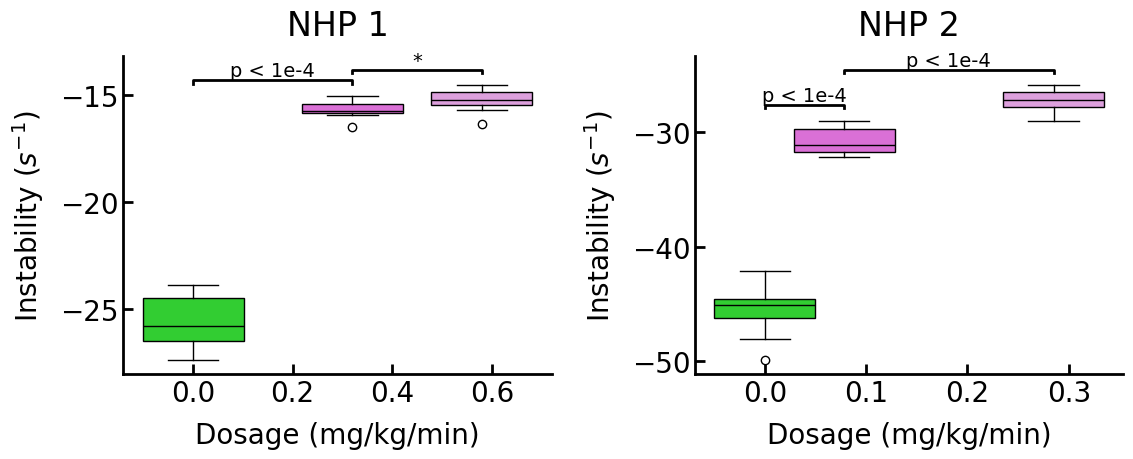

In [207]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
color_list = [section_colors['awake'], 'plum', 'orchid']
area = 'all'
for i, monkey in enumerate(monkeys):
    # axs[i].scatter(dosages[monkey], mean_stabs[monkey], color=pt_colors[monkey])
    dosage_vals = dosages[monkey].mean(axis=0)

    # if i == 2:
        
    bplot = axs[i].boxplot(dosage_data[monkey], 
                           positions=dosage_vals,
                           patch_artist=True,
                            manage_ticks=False,
                           # bootstrap=1000,
                           medianprops=dict(color='k'),
                           widths = dosage_vals.max()*0.35
                          )
    max_vals = np.array([item.get_ydata()[1] for item in bplot['whiskers']])[1::2]
    for patch, color in zip(bplot['boxes'], color_list):
        patch.set_facecolor(color)
    axs[i].set_xlabel('Dosage (mg/kg/min)')
    axs[i].set_title(f"NHP {i + 1}")
    axs[i].set_ylabel(f'Instability ' + r'($s^{-1}$)')
    axs[i].spines[['right', 'top']].set_visible(False)
    axs[i].xaxis.set_ticks_position('bottom')
    axs[i].tick_params(axis='y', which='both', left=True, right=False)

    dh = 0.04
    gap = 0.6
    barh = 0.01
    p_fontsize=14
    p = scipy.stats.mannwhitneyu(stab_means[monkey][area]['maintenance dose'], stab_means[monkey][area]['loading dose'], alternative='less').pvalue
    barplot_annotate_brackets(1, 2, p, dosage_vals, max_vals, yerr=np.zeros(3), scale_by_height=False, ax=axs[i], it=0, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=False)

    # # dh = 0.00000001
    # if i == 1:
    #     # dh = 0.00001
    #     # gap = 0
    #     # dh = 0
    #     # barh = 0
    #     print("THIS CALL")
    p = scipy.stats.mannwhitneyu(stab_means[monkey][area]['awake'], stab_means[monkey][area]['maintenance dose'], alternative='less').pvalue
    barplot_annotate_brackets(0, 2, p, dosage_vals, max_vals, yerr=np.zeros(3), scale_by_height=False, ax=axs[i], it=0, dh=dh, barh=barh, gap=gap, fs=p_fontsize, below=False)

plt.tight_layout()

### Recovery stabilized neural dynamics

In [274]:
monkey = 'Mary'
# scipy.stats.ks_2samp(stab_all[monkey][area]['unconscious'], stab_all[monkey][area]['recovery'])\
print(f"{monkey}, all: {scipy.stats.mannwhitneyu(stab_means[monkey][area]['unconscious'], stab_means[monkey][area]['recovery'], alternative='greater')}")
print(f"n unconscious = {len(stab_means[monkey][area]['unconscious'])}, n recovery = {len(stab_means[monkey][area]['recovery'])}")

Mary, all: MannwhitneyuResult(statistic=100.0, pvalue=9.133589555477501e-05)
n unconscious = 10, n recovery = 10


In [275]:
monkey = 'MrJones'
# scipy.stats.ks_2samp(stab_all[monkey][area]['unconscious'], stab_all[monkey][area]['recovery'])
# scipy.stats.mannwhitneyu(stab_all[monkey][area]['unconscious'], stab_all[monkey][area]['recovery'], alternative='greater')
print(f"{monkey}, all: {scipy.stats.mannwhitneyu(stab_means[monkey][area]['unconscious'], stab_means[monkey][area]['recovery'], alternative='greater')}")
print(f"n unconscious = {len(stab_means[monkey][area]['unconscious'])}, n recovery = {len(stab_means[monkey][area]['recovery'])}")

MrJones, all: MannwhitneyuResult(statistic=121.0, pvalue=4.075768063871622e-05)
n unconscious = 11, n recovery = 11


### Stability during recovery was closer to that of the awake state than the unconscious state

In [350]:
top_percent = 0.1

section_info = [('awake', [-15, 0]), ('unconscious', [15, 60]), ('recovery', [75, 85]), ('loading dose', [20, 30]), ('maintenance dose', [50, 60])]

total_its = 0
areas_comp = ['all']
for area in areas_comp:
    for session, session_dict in session_rets.items():
        total_its += len(section_info)
        
iterator = tqdm(total=total_its)

stab_all_vals = {}
for monkey in monkeys:
    stab_all_vals[monkey] = {}
    # for area in stability_all[monkey].keys():
    for area in areas_comp:
        stab_all_vals[monkey][area] = {}
        for session_ind, (session, session_dict) in enumerate(session_dicts[monkey].items()):
            stab_all_vals[monkey][area][session] = {}
            df = session_dict['results_dict'][area]
            for section, bounds in section_info:
                filter_inds = ((df.start_time - session_dict['session_info']['drugStart'][0])/60 >= bounds[0]) & ((df.start_time - session_dict['session_info']['drugStart'][0])/60 <= bounds[1])
                stab_all_vals[monkey][area][session][section] = np.hstack(df[filter_inds].stability_params.apply(lambda x: x[:int(top_percent*len(x))]))
                # stab_all_vals[monkey][area][session][section] = np.hstack(df[filter_inds].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()))
                iterator.update()
iterator.close()

  0%|          | 0/105 [00:00<?, ?it/s]

In [351]:
CMV_diffs = {}
for monkey in monkeys:
    CMV_diffs[monkey] = {}
    for area in areas_comp:
        CMV_diffs[monkey][area] = np.zeros(len(list(stab_all_vals[monkey][area].keys())))
        for session_ind, session in enumerate(stab_all_vals[monkey][area].keys()):
            cmv1 = scipy.stats.cramervonmises_2samp(stab_all_vals[monkey][area][session]['awake'], stab_all_vals[monkey][area][session]['unconscious'])
            cmv2 = scipy.stats.cramervonmises_2samp(stab_all_vals[monkey][area][session]['awake'], stab_all_vals[monkey][area][session]['recovery'])
            CMV_diffs[monkey][area][session_ind] = cmv1.statistic - cmv2.statistic

In [356]:
for monkey in monkeys:
    for area in areas_comp:
        print(f"{monkey}, {area}: {scipy.stats.ttest_1samp(CMV_diffs[monkey][area], 0)}")

Mary, all: TtestResult(statistic=27.69136985052839, pvalue=5.070352059614524e-10, df=9)
MrJones, all: TtestResult(statistic=17.489849606771518, pvalue=7.928601792445818e-09, df=10)
